# Matches

In [2]:
# Setup ipython environment
%load_ext autoreload
%autoreload 2
%matplotlib inline
from matplotlib.pyplot import *
from numpy import *
from positive import *
from nrutils import scsearch, gwylm
from pwca import *
from glob import glob
import lalsimulation as lalsim
from nrutils.analyze.match import match as match_object

(positive)>> Applying custom matplotlib settings.
(init)>> Warm greetings from Welsh Puck (aka pwca).
(pwca.core)>> Catalog of calibration runs stored to "pwca.pwca_catalog"
(pwca.core)>> Metadata dictionary for calibration runs stored to "pwca.metadata_dict"
(pwca.core)>> Metadata dictionary for Ed's catalog paper stored to "pwca.catalog_paper_metadata"


q1a04t120dP0T965 			4.41850771709662e-05 			0.0002223108126944151 			0.000420151064270069 			False
q1a08t90dPm1T964 			4.942463844748168e-06 			0.0006363113550065247 			0.0013368559278359449 			False
q1a08t30dPm25T96 			1.4326353766414002e-05 			0.000252849251278886 			0.0008840036659910622 			False
q1a04t60dPm1T965 			1.083126782519539e-05 			0.00012449998041552668 			0.0003962375734257728 			False
q1a08t60dPm1.5T9 			7.575013936556019e-06 			0.0008885860989662486 			0.0016123477473330983 			False
q1a08t120dP0T964 			5.5368784210863e-06 			0.0003792330422611734 			0.001078280037638879 			False
q1a08t150dP0T964 			9.210588209906945e-06 			0.00018286946949785943 			0.00036431348871035496 			False
q1a04t30dPm2T965 			3.814735269724867e-05 			0.0005033919679873211 			0.00029645793244625906 			True
q1a04t150dP0T965 			9.231970664058675e-05 			0.00027494937185301715 			0.0004645584666579383 			False
q1a04t90dP0T9655 			7.33668928043496e-05 			0.0002683099570260916 			0.0006121575161448511 	

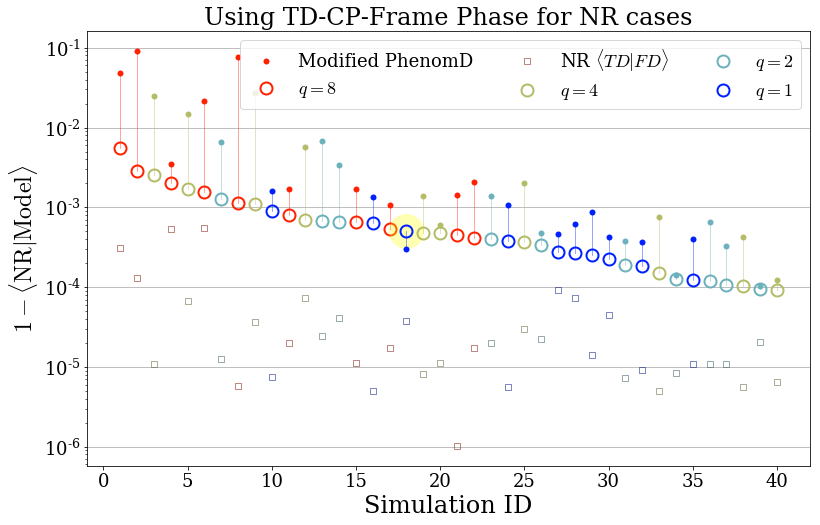

In [20]:

#
package_dir = parent( pwca.__path__[0] )
datadir = package_dir + 'data/version2/'
files = glob( datadir+'q*.txt' )

#
fref = 20

#
q_list = []
for a in pwca_catalog:
    q_list.append( int( round(a.m1/a.m2,2) ) )
mask = argsort(q_list)
pwca_catalog = array(pwca_catalog)[mask]

match_list = []
mod_phenomd_match_list = []
nr_match_list = []
kk = 0
for a in pwca_catalog:
    
    #
    file_ = [ k for k in files if a.simname in k ][0]
    
    #
    Msol = 100.0
    Dmpc = 1000.0
    #
    theta = 0
    phi   = 0
    #
    fmin = 30.0
    fmax = 300.0
    
    # Load data for this case
    raw_data = loadtxt(file_)
    f,amp_td,amp_fd,dphi_td,dphi_fd,phi_td,phi_fd = raw_data.T
    
    # Define holder for TD CP frame FD data
    hcode,hphys = {},{}
    key = 'td'
    hcode_ = amp_td * exp( 1j * phi_td ) * sYlm(-2,2,2,theta,phi)
    hcode[key] = array([f,hcode_*0.5,hcode_*0.5*1j]).T
    
    # Define holder for FD CP frame FD data
    key = 'fd'
    hcode_ = amp_fd * exp( 1j * phi_td ) * sYlm(-2,2,2,theta,phi)
    hcode[key] = array([f,hcode_*0.5,hcode_*0.5*1j]).T

    # Generate NR FD waveform array
    # ------------------------------------------------ #
    mask = f>0
    f     = f[mask]
    for k in hcode:
        hcode[k] = hcode[k][mask,:]
        hphys[k] = physhf(hcode[k],Msol,Dmpc)

    # Generate MODEL FD waveform array
    # ------------------------------------------------ #
    
    if linalg.norm(a.X1)<1e-3:
        m1,m2 = a.m2,a.m1
        X1,X2 = a.X2,a.X1
        a.m1,a.m2 = m1,m2
        a.X1,a.X2 = X1,X2
    
    # External 2-spin mapping
    chi_p    = calc_chi_p(a.m1,a.X1,a.m2,a.X2,a.L)
    a1,model_theta = calc_effective_a1_theta( a.m1, a.m2, a.X1, a.X2, a.L )
    # Find index location of metadata for simname 
    k = [ z.split('.')[0] for z in pwca.metadata_dict['simname'] ].index(a.simname.split('.')[0])
    model_theta,m1,m2,eta,delta,chi_eff,chi_p,chi1,chi2,a1,a2 = pwca.metadata_dict['array_data'][k]
    
    # Generate a coprecessing waveform as 1D array (NEW INPUT STRUCTURE)
    hmodel = generate_pwca_waveform_helper( f, model_theta, eta, a1, chi1,chi2, chi_p, fref=fref ) * sYlm(-2,2,2,theta,phi)
    
    # Generate a coprecessing waveform as 1D array
    #hmodel = generate_pwca_waveform( f, a.m1, a.m2, a.X1, a.X2, a.L ) * sYlm(-2,2,2,theta,phi)
    #print sum(abs(hmodel-hmodel_old))/sum(abs(hmodel_old))
    
    hmodel_p = 0.5*(hmodel)
    hmodel_c = -1j*0.5*(hmodel)
    hcode_model = array([f,hmodel_p,hmodel_c]).T
    hphys_model = physhf( hcode_model,Msol,Dmpc )
    
    #
    mod_phenomd = generate_modified_phenomd(f, a.m1, a.m2, a.X1, a.X2, a.L)
    mod_phenomd_p = 0.5*(mod_phenomd)
    mod_phenomd_c = -1j*0.5*(mod_phenomd)
    mod_phenomd_code = array([f,mod_phenomd_p,mod_phenomd_c]).T
    mod_phenomd_phys = physhf( mod_phenomd_code,Msol,Dmpc )

    #
    ref_key = 'td'
    phys_signal   = hphys[ref_key]
    phys_template = hphys_model

    # Create match object
    mo1 = match_object( phys_template,    phys_signal, fmin=fmin, fmax=fmax, signal_polarization=0, positive_f=True, psd_thing = lalsim.SimNoisePSDaLIGOZeroDetHighPower )
    mo2 = match_object( mod_phenomd_phys, phys_signal, fmin=fmin, fmax=fmax, signal_polarization=0, positive_f=True, psd_thing = lalsim.SimNoisePSDaLIGOZeroDetHighPower )
    mo3 = match_object( hphys['fd'], phys_signal, fmin=fmin, fmax=fmax, signal_polarization=0, positive_f=True, psd_thing = lalsim.SimNoisePSDaLIGOZeroDetHighPower )

    mx  = mo1.calc_template_pol_optimized_match()
    mxd = mo2.calc_template_pol_optimized_match()
    mx3 = mo3.calc_template_pol_optimized_match()
    print a.simname.replace('_','')[:16],'\t\t\t',1-mx3,'\t\t\t',1-mx,'\t\t\t',1-mxd,'\t\t\t',mxd>mx
    match_list.append(mx)
    mod_phenomd_match_list.append(mxd)
    nr_match_list.append(mx3)


figure(figsize=2*figaspect(0.618))

mask = argsort(match_list)

clr=rgb(4,jet=True)

q_set = [1,2,4,8][::-1]
passed_q = []
for k,a in enumerate(pwca_catalog[mask]):

    if mod_phenomd_match_list[ mask[k] ] > match_list[ mask[k] ]:
        plot( k+1, 1-match_list[ mask[k] ], mew=0, ms=35, ls='none', marker='o', color='yellow', alpha=0.3 )
        
    q = int( round(a.m1/a.m2,2) )
    plot( k+1, 1-mod_phenomd_match_list[ mask[k] ], mew=0, ms=6, ls='none', marker='o', color=clr[q_set.index(q)], label= 'Modified PhenomD' if not k else None )
    plot( k+1, 1-match_list[ mask[k] ], mew=2, ms=12, ls='none', marker='o', mfc='none', color=clr[q_set.index(q)], label= '$q=%i$'%q if not (q in passed_q) else None )
    plot( k+1, 1-nr_match_list[ mask[k] ], mew=0.5, ms=6, ls='none', marker='s', mfc='none', color=0.5*clr[q_set.index(q)], label= r'NR $\langle TD | FD \rangle$' if not k else None )
    plot( [k+1,k+1],[1-mod_phenomd_match_list[ mask[k] ],1-match_list[ mask[k] ]], color=clr[q_set.index(q)], alpha=0.5 )
    passed_q.append(q)
    
    #axhline(1e-2,ls='--',color='m')
    yscale('log')
    xlabel('Simulation ID')
    ylabel(r'$1-\langle \mathrm{NR} | \mathrm{Model} \rangle$')
    grid(True,axis='y')
    
    legend(ncol=3,frameon=True)
    title('Using TD-CP-Frame Phase for NR cases')
    
#
# savefig('/Users/book/KOALA/puck/ll/data/version2/matches_diagnostic.pdf')
yl = ylim()

q1a04t120dP0T965 			0.00031785919273208396 			0.0002223108126944151 			0.000420151064270069 			False
q1a08t90dPm1T964 			4.571841859180026e-05 			0.0006363113550065247 			0.0013368559278359449 			False
q1a08t30dPm25T96 			8.780027901889031e-05 			0.000252849251278886 			0.0008840036659910622 			False
q1a04t60dPm1T965 			0.00011928948246620052 			0.00012449998041552668 			0.0003962375734257728 			False
q1a08t60dPm1.5T9 			0.0009003081673926161 			0.0008885860989662486 			0.0016123477473330983 			False
q1a08t120dP0T964 			8.229488749167402e-05 			0.0003792330422611734 			0.001078280037638879 			False
q1a08t150dP0T964 			3.695589575236635e-05 			0.00018286946949785943 			0.00036431348871035496 			False
q1a04t30dPm2T965 			0.00021190454195263442 			0.0005033919679873211 			0.00029645793244625906 			True
q1a04t150dP0T965 			0.0002449079267989873 			0.00027494937185301715 			0.0004645584666579383 			False
q1a04t90dP0T9655 			0.0003706360171814582 			0.0002683099570260916 			0.000612157516144

(5.774112138060329e-07, 0.16250474679654614)

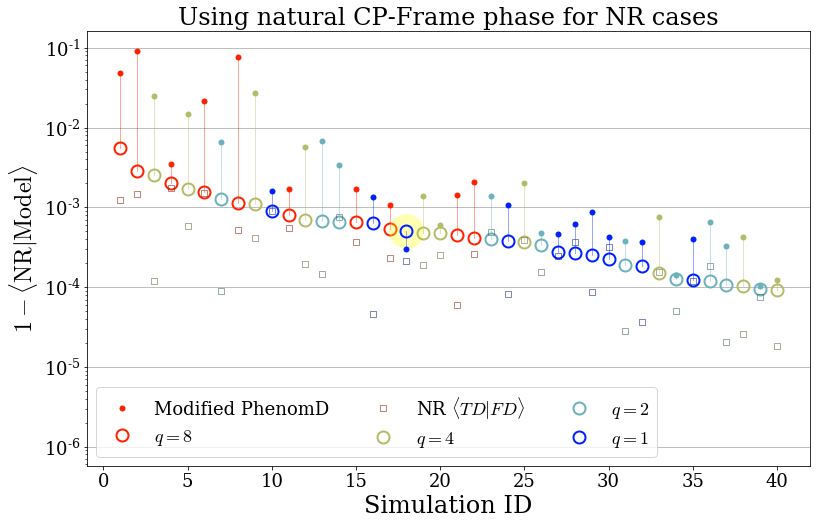

In [22]:

#
package_dir = parent( pwca.__path__[0] )
datadir = package_dir + 'data/version2/'
files = glob( datadir+'q*.txt' )

#
fref = 20

#
q_list = []
for a in pwca_catalog:
    q_list.append( int( round(a.m1/a.m2,2) ) )
mask = argsort(q_list)
pwca_catalog = array(pwca_catalog)[mask]

match_list = []
mod_phenomd_match_list = []
nr_match_list = []
kk = 0
for a in pwca_catalog:
    
    #
    file_ = [ k for k in files if a.simname in k ][0]
    
    #
    Msol = 100.0
    Dmpc = 1000.0
    #
    theta = 0
    phi   = 0
    #
    fmin = 30.0
    fmax = 300.0
    
    # Load data for this case
    raw_data = loadtxt(file_)
    f,amp_td,amp_fd,dphi_td,dphi_fd,phi_td,phi_fd = raw_data.T
    
    # Define holder for TD CP frame FD data
    hcode,hphys = {},{}
    key = 'td'
    hcode_ = amp_td * exp( 1j * phi_td ) * sYlm(-2,2,2,theta,phi)
    hcode[key] = array([f,hcode_*0.5,hcode_*0.5*1j]).T
    
    # Define holder for FD CP frame FD data
    key = 'fd'
    hcode_ = amp_fd * exp( 1j * phi_fd ) * sYlm(-2,2,2,theta,phi)
    hcode[key] = array([f,hcode_*0.5,hcode_*0.5*1j]).T

    # Generate NR FD waveform array
    # ------------------------------------------------ #
    mask = f>0
    f     = f[mask]
    for k in hcode:
        hcode[k] = hcode[k][mask,:]
        hphys[k] = physhf(hcode[k],Msol,Dmpc)

    # Generate MODEL FD waveform array
    # ------------------------------------------------ #
    
    if linalg.norm(a.X1)<1e-3:
        m1,m2 = a.m2,a.m1
        X1,X2 = a.X2,a.X1
        a.m1,a.m2 = m1,m2
        a.X1,a.X2 = X1,X2
    
    # External 2-spin mapping
    chi_p    = calc_chi_p(a.m1,a.X1,a.m2,a.X2,a.L)
    a1,model_theta = calc_effective_a1_theta( a.m1, a.m2, a.X1, a.X2, a.L )
    # Find index location of metadata for simname 
    k = [ z.split('.')[0] for z in pwca.metadata_dict['simname'] ].index(a.simname.split('.')[0])
    model_theta,m1,m2,eta,delta,chi_eff,chi_p,chi1,chi2,a1,a2 = pwca.metadata_dict['array_data'][k]
    
    # Generate a coprecessing waveform as 1D array (NEW INPUT STRUCTURE)
    hmodel = generate_pwca_waveform_helper( f, model_theta, eta, a1, chi1,chi2, chi_p, fref=fref ) * sYlm(-2,2,2,theta,phi)
    
    # Generate a coprecessing waveform as 1D array
    #hmodel = generate_pwca_waveform( f, a.m1, a.m2, a.X1, a.X2, a.L ) * sYlm(-2,2,2,theta,phi)
    #print sum(abs(hmodel-hmodel_old))/sum(abs(hmodel_old))
    
    hmodel_p = 0.5*(hmodel)
    hmodel_c = -1j*0.5*(hmodel)
    hcode_model = array([f,hmodel_p,hmodel_c]).T
    hphys_model = physhf( hcode_model,Msol,Dmpc )
    
    #
    mod_phenomd = generate_modified_phenomd(f, a.m1, a.m2, a.X1, a.X2, a.L)
    mod_phenomd_p = 0.5*(mod_phenomd)
    mod_phenomd_c = -1j*0.5*(mod_phenomd)
    mod_phenomd_code = array([f,mod_phenomd_p,mod_phenomd_c]).T
    mod_phenomd_phys = physhf( mod_phenomd_code,Msol,Dmpc )

    #
    ref_key = 'td'
    phys_signal   = hphys[ref_key]
    phys_template = hphys_model

    # Create match object
    mo1 = match_object( phys_template,    phys_signal, fmin=fmin, fmax=fmax, signal_polarization=0, positive_f=True, psd_thing = lalsim.SimNoisePSDaLIGOZeroDetHighPower )
    mo2 = match_object( mod_phenomd_phys, phys_signal, fmin=fmin, fmax=fmax, signal_polarization=0, positive_f=True, psd_thing = lalsim.SimNoisePSDaLIGOZeroDetHighPower )
    mo3 = match_object( hphys['fd'], phys_signal, fmin=fmin, fmax=fmax, signal_polarization=0, positive_f=True, psd_thing = lalsim.SimNoisePSDaLIGOZeroDetHighPower )

    mx  = mo1.calc_template_pol_optimized_match()
    mxd = mo2.calc_template_pol_optimized_match()
    mx3 = mo3.calc_template_pol_optimized_match()
    print a.simname.replace('_','')[:16],'\t\t\t',1-mx3,'\t\t\t',1-mx,'\t\t\t',1-mxd,'\t\t\t',mxd>mx
    match_list.append(mx)
    mod_phenomd_match_list.append(mxd)
    nr_match_list.append(mx3)


figure(figsize=2*figaspect(0.618))

mask = argsort(match_list)

clr=rgb(4,jet=True)

q_set = [1,2,4,8][::-1]
passed_q = []
for k,a in enumerate(pwca_catalog[mask]):

    if mod_phenomd_match_list[ mask[k] ] > match_list[ mask[k] ]:
        plot( k+1, 1-match_list[ mask[k] ], mew=0, ms=35, ls='none', marker='o', color='yellow', alpha=0.3 )
        
    q = int( round(a.m1/a.m2,2) )
    plot( k+1, 1-mod_phenomd_match_list[ mask[k] ], mew=0, ms=6, ls='none', marker='o', color=clr[q_set.index(q)], label= 'Modified PhenomD' if not k else None )
    plot( k+1, 1-match_list[ mask[k] ], mew=2, ms=12, ls='none', marker='o', mfc='none', color=clr[q_set.index(q)], label= '$q=%i$'%q if not (q in passed_q) else None )
    plot( k+1, 1-nr_match_list[ mask[k] ], mew=0.5, ms=6, ls='none', marker='s', mfc='none', color=0.5*clr[q_set.index(q)], label= r'NR $\langle TD | FD \rangle$' if not k else None )
    plot( [k+1,k+1],[1-mod_phenomd_match_list[ mask[k] ],1-match_list[ mask[k] ]], color=clr[q_set.index(q)], alpha=0.5 )
    passed_q.append(q)
    
    #axhline(1e-2,ls='--',color='m')
    yscale('log')
    xlabel('Simulation ID')
    ylabel(r'$1-\langle \mathrm{NR} | \mathrm{Model} \rangle$')
    grid(True,axis='y')
    
    legend(ncol=3,frameon=True)
    title('Using natural CP-Frame phase for NR cases')
    
#
ylim(yl)
# savefig('/Users/book/KOALA/puck/ll/data/version2/matches_diagnostic.pdf')

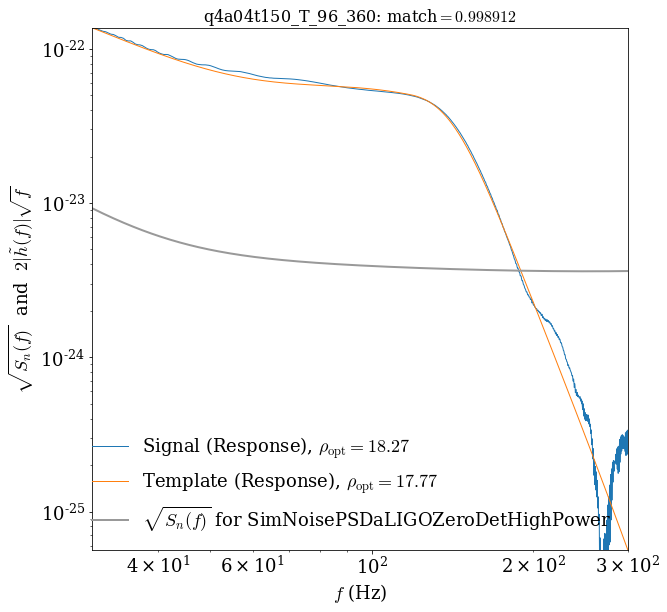

In [4]:
fig = mo.plot()
title('%s: match$=%f$'%(a.simname,mx));